In [1]:
import sys
dirname = '/Users/muhammaddaffarobani/Documents/personal_research/smt'
if dirname not in sys.path:
    sys.path.append(dirname)

import pandas as pd
import numpy as np
from smt.surrogate_models import KRG
from smt.problems import WingWeight
from smt.sampling_methods import LHS
from sklearn.metrics import mean_squared_error


from smt.applications.explainability_tools import (
    PartialDependenceDisplay, 
    PDFeatureImportanceDisplay, 
    PDFeatureInteractionDisplay,
    ShapFeatureImportanceDisplay,
    ShapDisplay,
    ShapDisplay2,
)


In [2]:
ndoe = 300 
fun = WingWeight()
sampling = LHS(xlimits=fun.xlimits, criterion='ese', random_state=1)
X = sampling(ndoe)
y = fun(X)

n_train = int(0.8 * ndoe)

X_tr, y_tr = X[:n_train, :], y[:n_train]
X_te, y_te = X[n_train:, :], y[n_train:]

## config
feature_names = [
    r'$S_{w}$', r'$W_{fw}$', r'$A$', r'$\Delta$', 
    r'$q$', r'$\lambda$', r'$t_{c}$', r'$N_{z}$', 
    r'$W_{dg}$', r'$W_{p}$',
]

class GroundTruthModel:
    def predict_values(self, X):
        return fun(X)

In [3]:
print("Ground truth model")
gtm = GroundTruthModel()
y_pred = gtm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")

Ground truth model
RMSE: 0.0000
rRMSE: 0.0000


In [4]:
sm = KRG(
    theta0=[1e-2]*X_tr.shape[1],
    print_prediction = False
    )
sm.set_training_values(
    X_tr, 
    y_tr
    )

sm.train()

print("Surrogate model")
y_pred = sm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 240
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  2.8093550
Surrogate model
RMSE: 0.1650
rRMSE: 0.0006


In [5]:
rmse

0.16498923000133303

CPU times: user 1.26 s, sys: 798 ms, total: 2.05 s
Wall time: 1.13 s


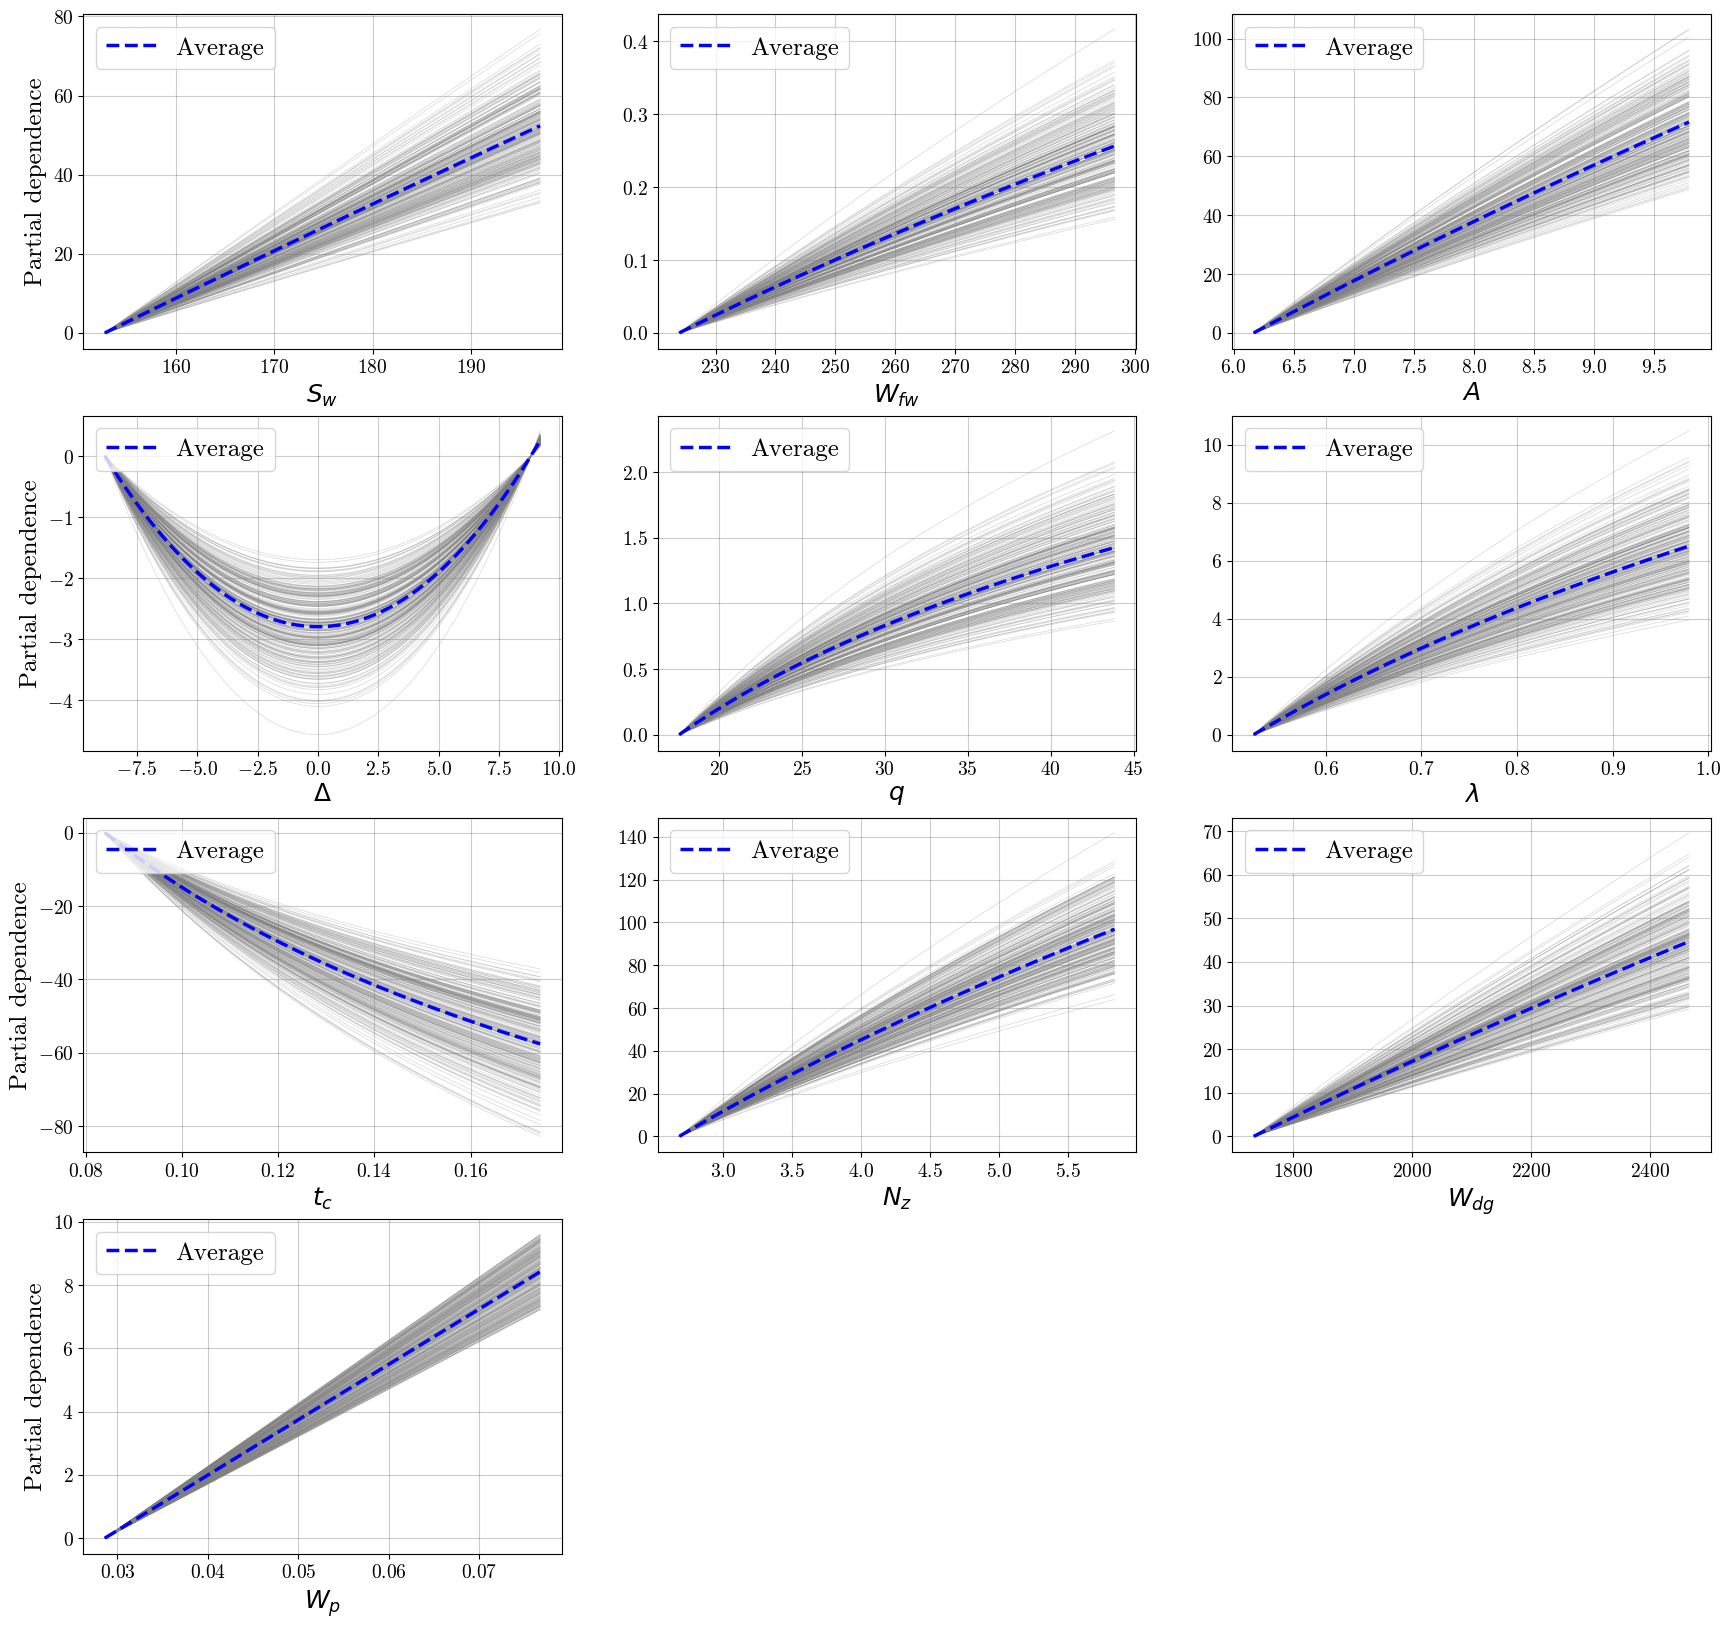

In [6]:
%%time
model = gtm
X = X_tr
features = [i for i in range(X_tr.shape[1])]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    grid_resolution=100, 
    kind='both',
    feature_names=feature_names,
    centered=True,
    )

CPU times: user 12.4 s, sys: 26.5 s, total: 39 s
Wall time: 5.36 s


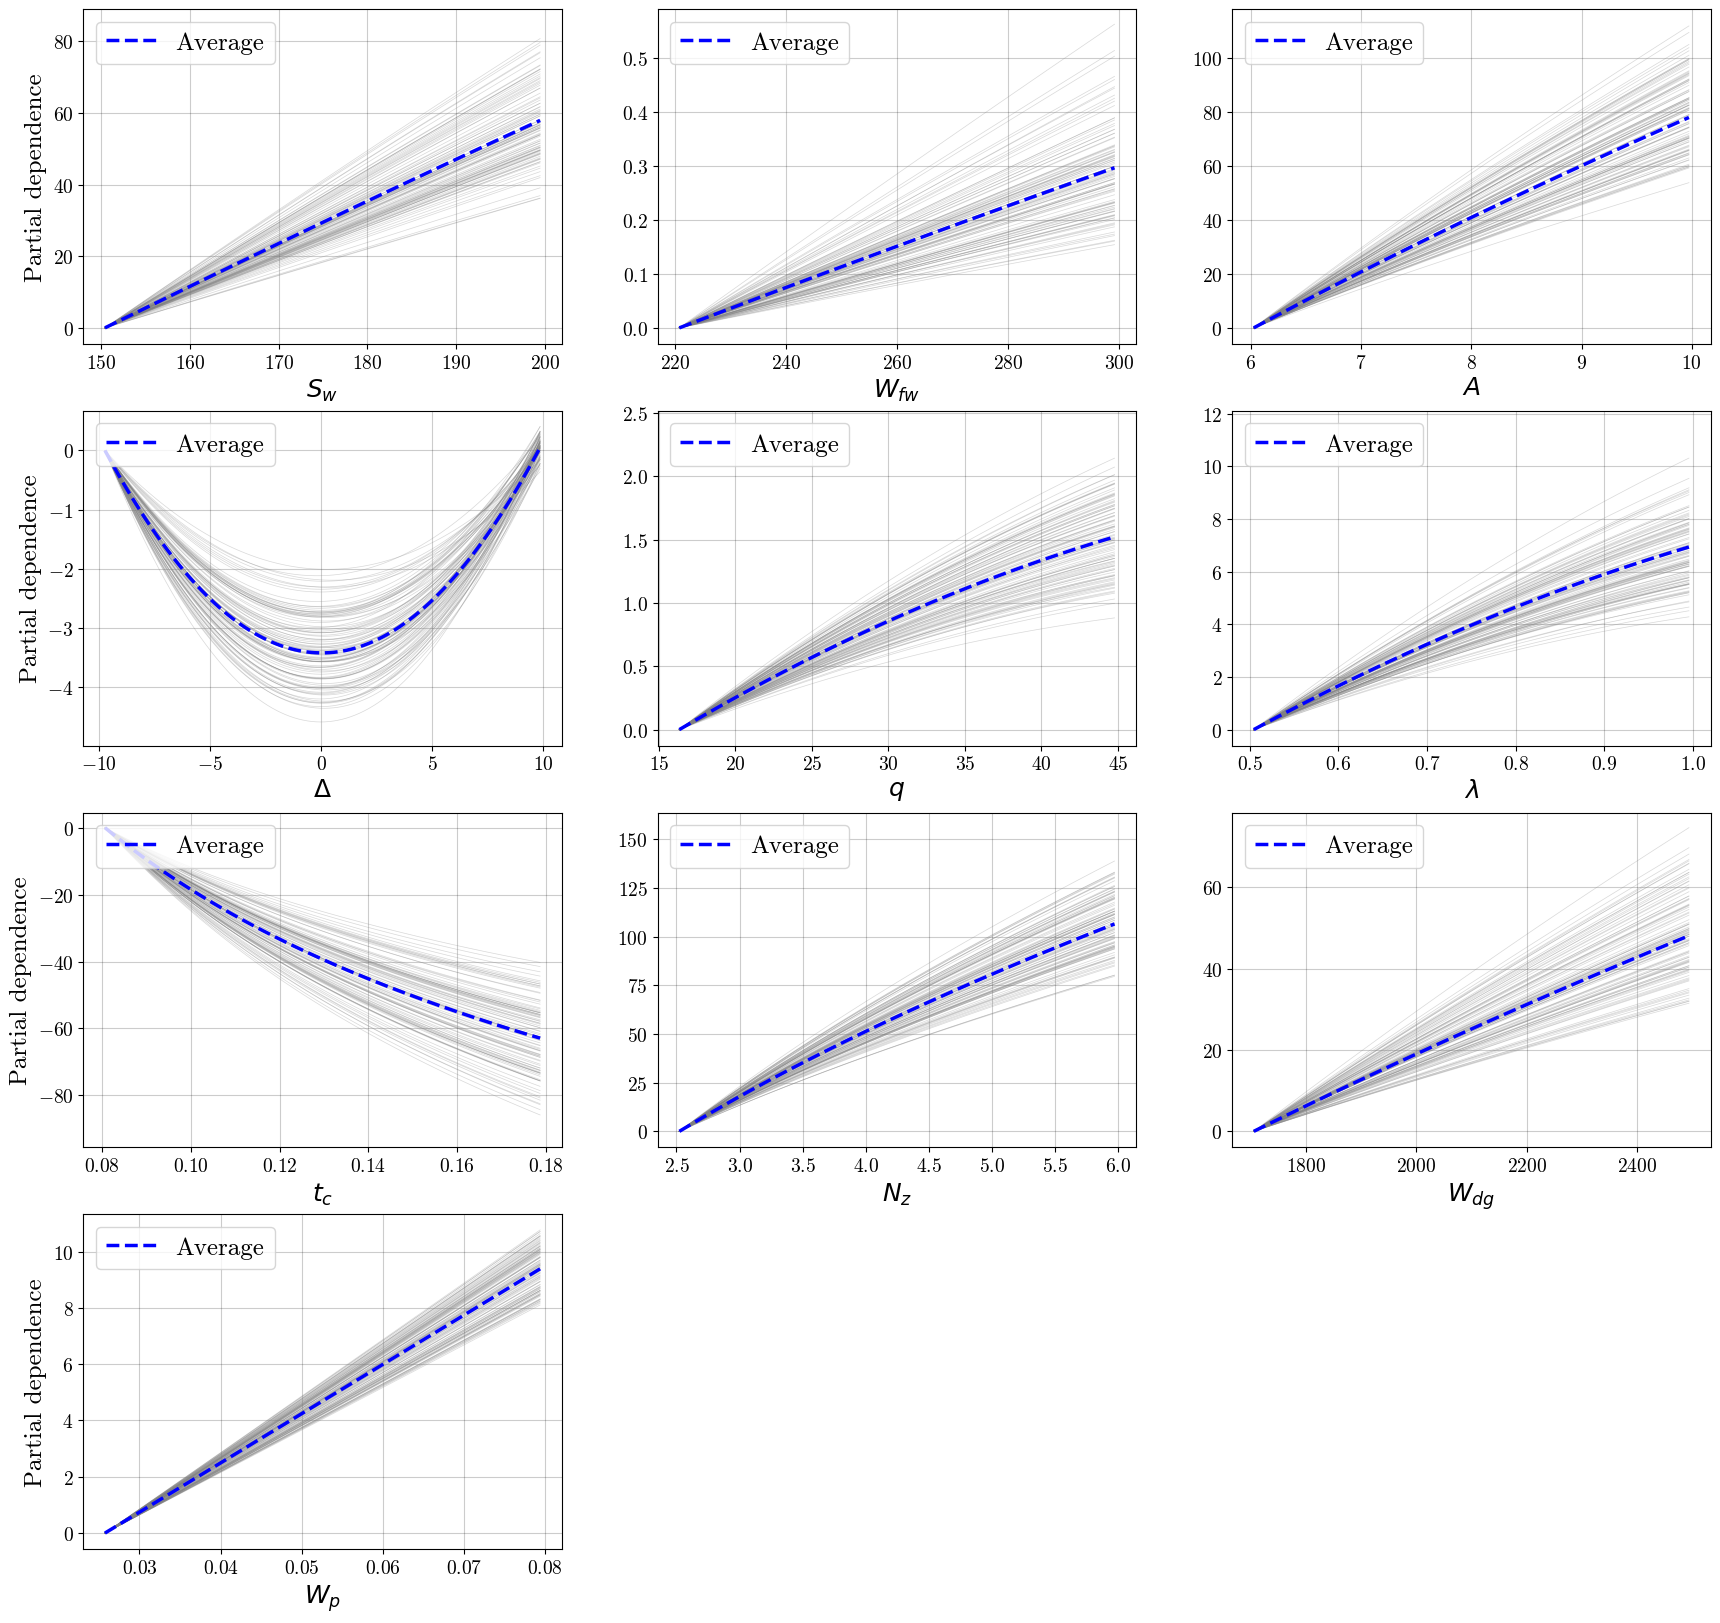

In [7]:
%%time
model = sm
X = X_tr
features = [i for i in range(X_tr.shape[1])]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    grid_resolution=100, 
    kind='both',
    feature_names=feature_names,
    centered=True,
    max_num_ice_lines=100, 
    percentiles=(0.01, 0.99)
    )

In [8]:
np.quantile(X[:, 0], 0.05)

152.87724777946892

In [9]:
# pdd.figure_.savefig("pdp_dependence_plot_wing_weight.pdf", format="pdf", bbox_inches="tight", dpi=750)

In [10]:
# %%time
# instances = X_tr
# model = gtm
# X = X_tr
# explainer_train_true = ShapDisplay.from_surrogate_model(
#     instances, 
#     model, 
#     X, 
#     feature_names=feature_names,
# )

In [11]:
%%time
instances = X_tr
model = sm
X = X_tr
explainer_train = ShapDisplay2.from_surrogate_model(
    instances, 
    model, 
    X, 
    feature_names=feature_names,
)

CPU times: user 1min 35s, sys: 1min 26s, total: 3min 2s
Wall time: 28.2 s


In [12]:
# %%time
# features = [i for i in range(X_tr.shape[1])]

# explainer_train_true.dependence_plot(features)

CPU times: user 658 ms, sys: 200 ms, total: 858 ms
Wall time: 148 ms


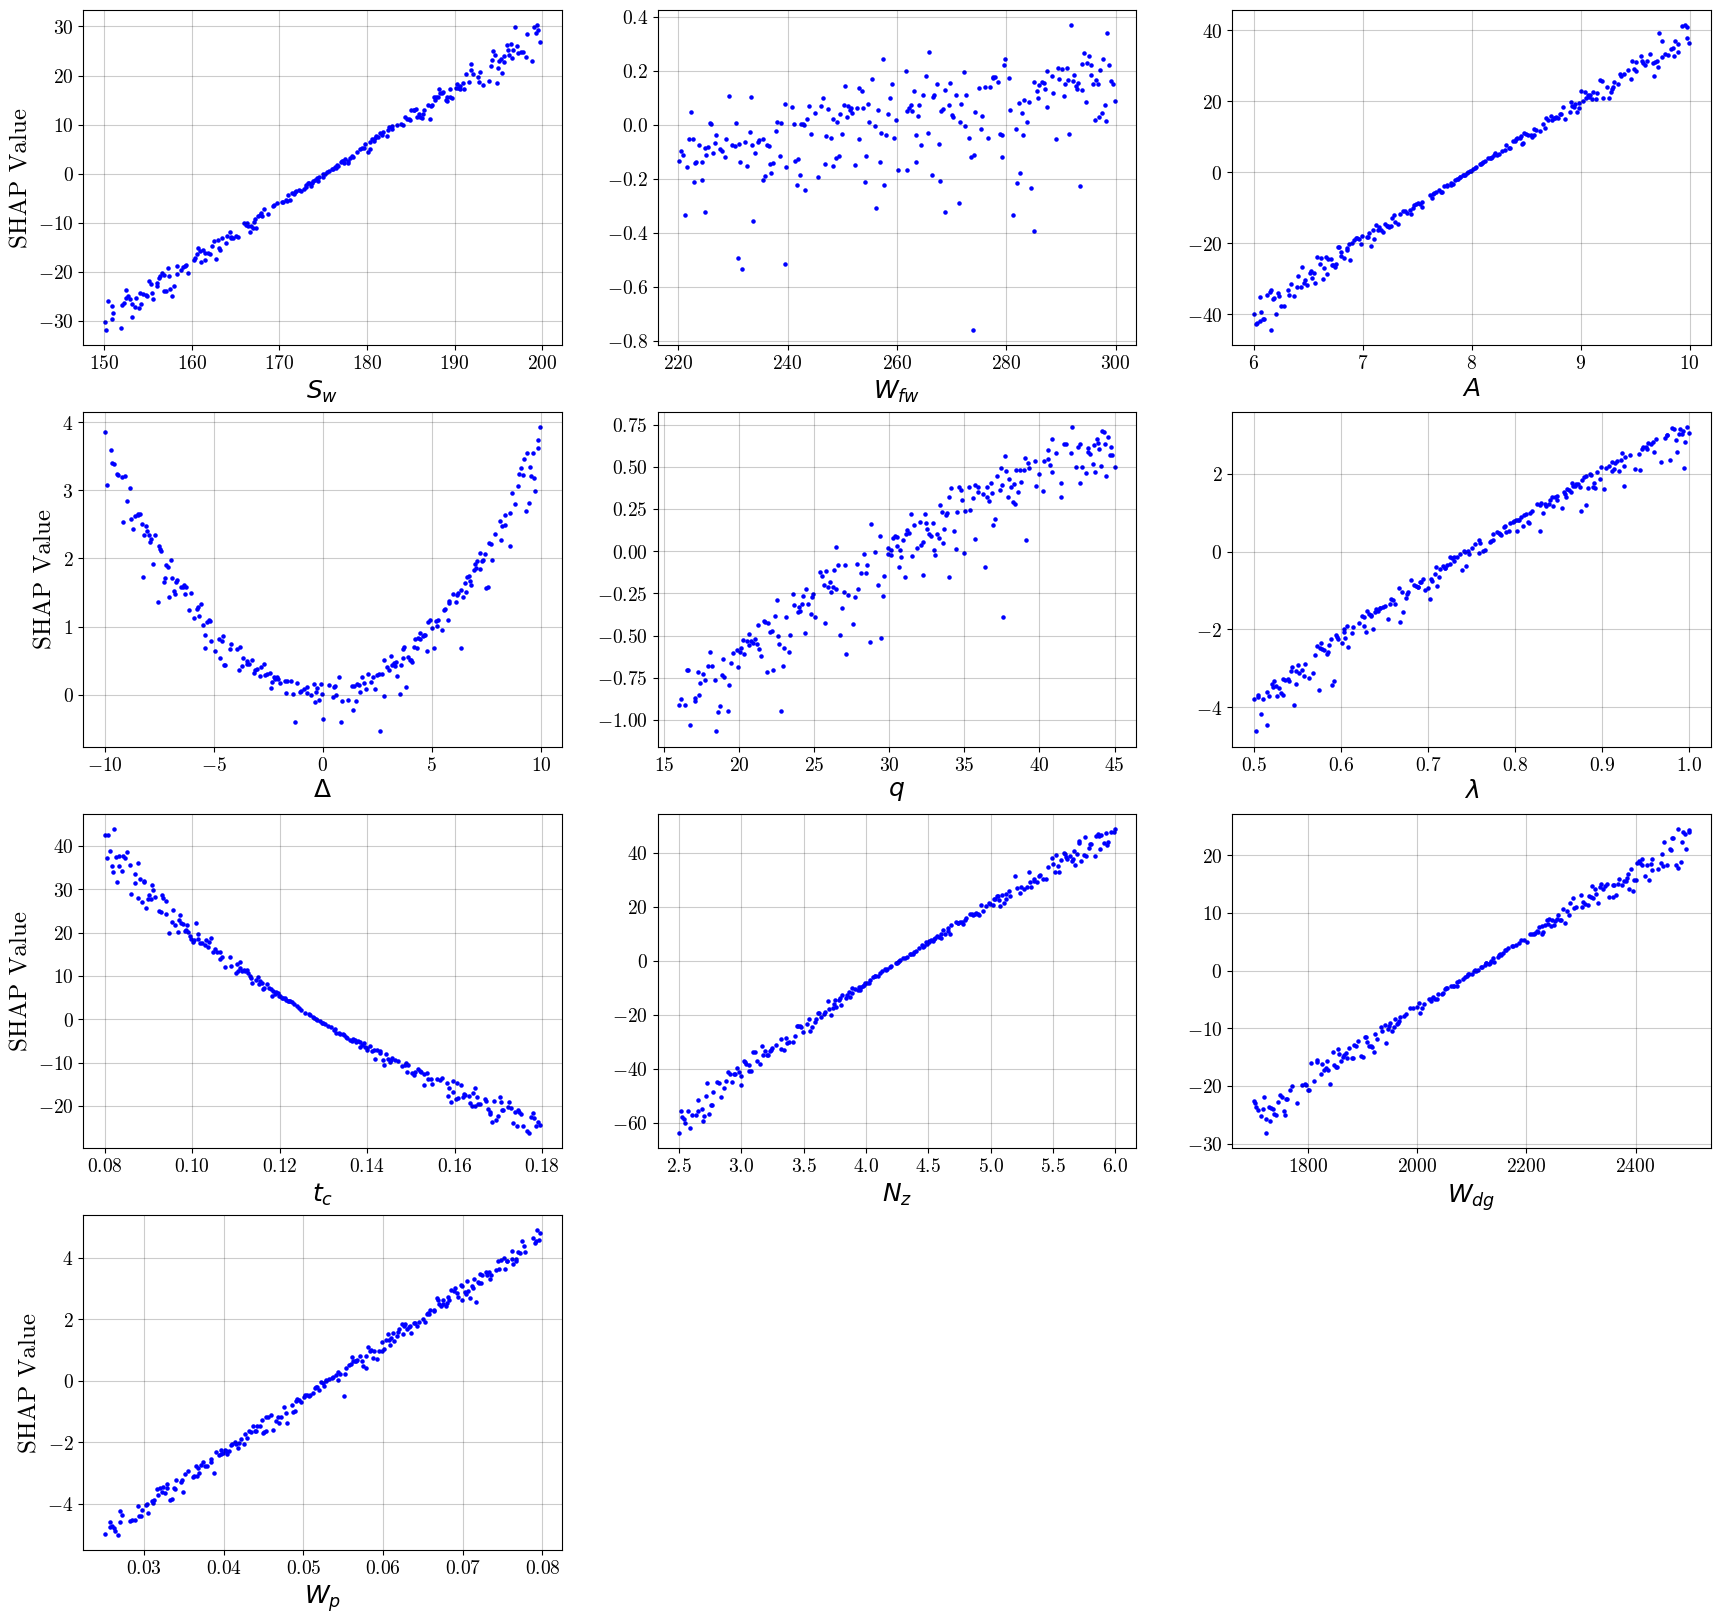

In [13]:
%%time
features = [i for i in range(X_tr.shape[1])]

shap_dependence = explainer_train.dependence_plot(features)

In [14]:
# %%time
# model = gtm
# X = X_tr

# feature_importance = PDFeatureImportanceDisplay.from_surrogate_model(
#     model, 
#     X, 
#     feature_names=feature_names,
# )

CPU times: user 33.9 s, sys: 10.5 s, total: 44.5 s
Wall time: 6.78 s


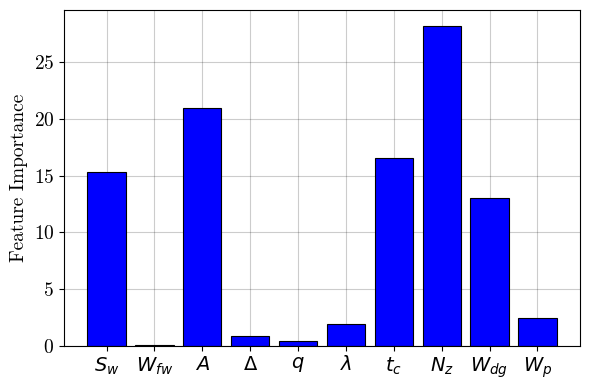

In [18]:
%%time
model = sm
X = X_tr

pd_feature_importance = PDFeatureImportanceDisplay.from_surrogate_model(
    model, 
    X, 
    feature_names=feature_names,
)

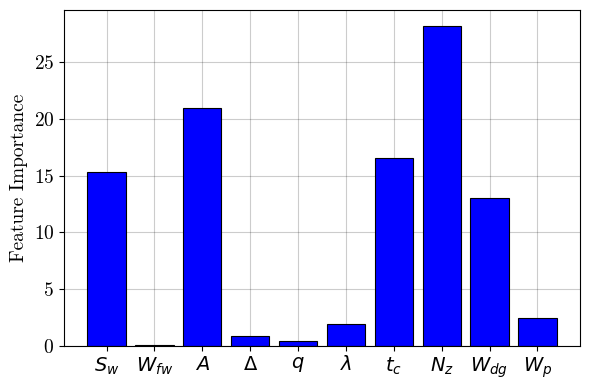

In [20]:
pd_feature_importance.fig

In [16]:
# %%time
# model = gtm
# X = X_tr

# feature_importance = ShapFeatureImportanceDisplay.from_surrogate_model(
#     model, 
#     X_tr, 
#     feature_names=feature_names,
# )

CPU times: user 1min 50s, sys: 1min 8s, total: 2min 59s
Wall time: 26.4 s


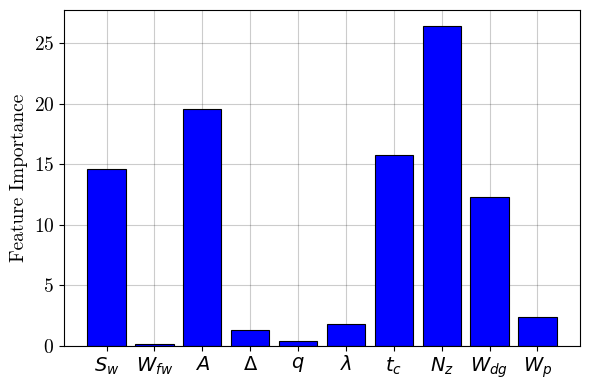

In [19]:
%%time
model = sm
X = X_tr

shap_feature_importance = ShapFeatureImportanceDisplay.from_surrogate_model(
    model, 
    X_tr, 
    feature_names=feature_names,
)

In [22]:
pdd.figure_.savefig("aiaa_abstract/wing_weight/pdp_dependence_plot_wing_weight.pdf", format="pdf", bbox_inches="tight", dpi=750)
shap_dependence.savefig("aiaa_abstract/wing_weight/shap_dependence_wing_weight.pdf", format="pdf", bbox_inches="tight", dpi=750)
pd_feature_importance.fig.savefig("aiaa_abstract/wing_weight/pdp_feature_importance.pdf", format="pdf", bbox_inches="tight", dpi=750)
shap_feature_importance.fig.savefig("aiaa_abstract/wing_weight/shap_feature_importance.pdf", format="pdf", bbox_inches="tight", dpi=750)

